In [20]:
import matplotlib.pyplot as plt
import numpy as np
from pymatgen.ext.matproj import MPRester
import plotly.graph_objects as go
import math

In [4]:
mp_key = "x6hAWrx1l7nO3pcKMHzrj9I3u9zQTpCo"
mp_id = "mp-924130"
m = MPRester(mp_key)
prim_struc = m.get_structure_by_material_id(mp_id)
ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Récupération des données

In [37]:

temperatures = np.arange(0.001,1000,5)
R = 8.314  # constante des gaz parfaits
nat = len(prim_struc)  # nombre d'atomes
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)  # array avec cv pour chaque température de temperatures

### Plot de la chaleur spécifique en fonction de la température pour l'objet téléchargé

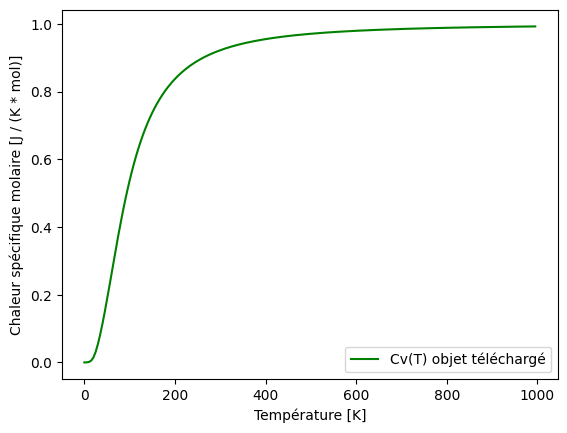

In [38]:
plt.plot(temperatures, ph_cv, color="green", label="Cv(T) objet téléchargé")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire [J / (K * mol)]")
plt.legend()
plt.show()

### Calcul des températures d'Einstein et de Debye

In [39]:
# Minimisation des fonctions d'Einstein et de Debye au sens des moindres carrés vis à vis de Cv(T) de l'objet téléchargé

# Définis fE (modèle d'Einstein) donc renvoie la chaleur spécifique molaire pour une température T et un paramètre ThetaE
def fE(ThetaE, T):
    toReturn = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
    if math.isnan(toReturn):
        toReturn = 0
    return toReturn

# Définis fD (modèle de Debye) donc renvoie la chaleur spécifique molaire pour une température T et un paramètre ThetaD
def fD(ThetaD, T):
    # Il va falloir intégrer de 0 à ThetaD/T. On va utiliser la méthode des trapèzes fournie par numpy
    # création d'un linspace pour l'intégrale
    x = np.linspace(0.00001, ThetaD/T, 50)  # Peut pas commencer à 0 sinon division par 0
    y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
    integral =  np.trapz(y, x)
    toReturn = 3 * (T / ThetaD)**3 * integral
    if math.isnan(toReturn):  # Peut arriver si T = 0
        toReturn = 0
    return toReturn
    

# Fonction SquaredError générale
def getSquaredError(Parameter, T, Cv, f):
    squaredError = 0
    for i in range(len(T)):
        # print(f"Cv[i] = {Cv[i]}, f(Parameter, T[i]) = {f(Parameter, T[i])}")
        squaredError += (Cv[i] - f(Parameter, T[i]))**2
    return squaredError

# Trouve le minimale de la fonction f, cherche entre les valeurs de start et end avec un pas step
def find_minima(start, end, step, T, Cv, f):
    numbers = np.arange(start, end, step=step)
    result = []
    for i in range(len(numbers)):
        result.append(getSquaredError(numbers[i], T, Cv, f))
    return numbers[np.argmin(result)]

# J'ai affiné les intervalles de recherche pour les minimas en fonction des résultats obtenus à chaque itération
tE = find_minima(270, 285, 0.01, temperatures, ph_cv, fE)  # Trouve la température d'Einstein minimisant l'erreur
tD = find_minima(372, 379, 0.01, temperatures, ph_cv, fD)  # Trouve la température de Debye minimisant l'erreur

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:5: RuntimeWarning:

overflow encountered in exp

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:5: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:15: RuntimeWarning:

overflow encountered in exp

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:15: RuntimeWarning:

invalid value encountered in divide



In [40]:
print(f"La température d'Einstein minimisant l'erreur est {tE} K")
print(f"La température de Debye minimisant l'erreur est {tD} K")

La température d'Einstein minimisant l'erreur est 278.3299999999924 K
La température de Debye minimisant l'erreur est 376.31999999999607 K


### Représentation des 3 courbes de chaleur spécifique

In [42]:
# Calcul des courbes d'Einstein et de Debye avec les paramètres trouvés
# Courbe modèle d'Einstein
Cv_einstein = []
for t in temperatures:
    Cv_einstein.append(fE(tE, t))

# Courbe modèle de Debye
Cv_debye = []
for t in temperatures:
    Cv_debye.append(fD(tD, t))

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:5: RuntimeWarning:

overflow encountered in exp

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:5: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:15: RuntimeWarning:

overflow encountered in exp

C:\Users\Boss\AppData\Local\Temp\ipykernel_8112\1061858478.py:15: RuntimeWarning:

invalid value encountered in divide



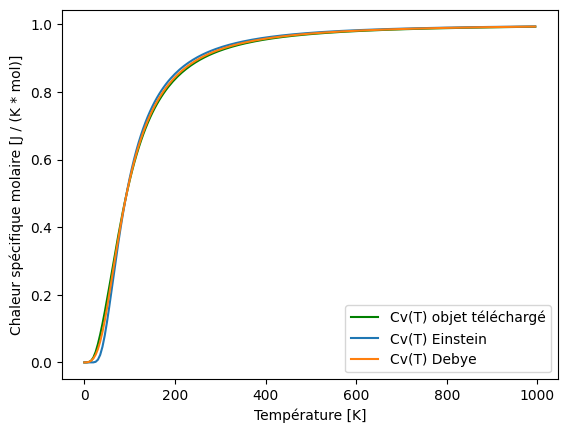

In [43]:
# Affichage des résultats
plt.plot(temperatures, ph_cv, color="green", label="Cv(T) objet téléchargé")
plt.plot(temperatures, Cv_einstein, label="Cv(T) Einstein")
plt.plot(temperatures, Cv_debye, label="Cv(T) Debye")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire [J / (K * mol)]")
plt.legend()
plt.show()

### Représentation des densités d'état de phonons correpondantes

Dans le modèle d'Einstein, la densité d'états est un delta de dirac en $\omega_E$ donc en $f_E = (k_b * \theta_E) / h$ (car $k_b * T= \hbar * \omega_E$) .

Dans le modèle de Debye, $g(w)$ est une fonction parabolique de la fréquence $g_D(w) = (9 * Nat * \omega^2) / \omega_D^3$ ce qui me donne en fréquentiel :
$g_D(f) = (9 * Nat * f^2) / (2 * \pi * f_D^3)$ où $\omega_D$ et $f_D$ sont la pulsation et la fréquence de Debye.

$f_D$ est donnée par $f_D = (k_b * \theta_D) / h$ .

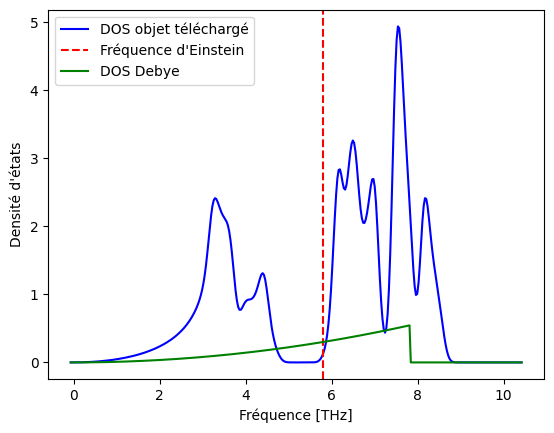

In [71]:
# Récupération des fréquences et des densités d'états pour le modèle téléchargé
freq = ph_dos.frequencies
densities = ph_dos.densities

#Constantes
kb = 1.38064852e-23 # constante de Boltzmann
h = 6.62607015e-34 # constante de Planck

# Calcul de la fréquence de Einstein en THz
fE = tE * kb / h / 10**12

# Calcul de la fréquence de Debye en THz
fD = tD * kb / h / 10**12

# Calcul de la densité d'états de Debye
gD = np.zeros_like(freq)
for i in range(len(freq)):
    if freq[i] < fD:
        gD[i] = 9 * nat * freq[i]**2 / (2 * np.pi * fD**3)

plt.plot(freq, densities, color="blue", label="DOS objet téléchargé")
plt.axvline(x=fE, color='r', linestyle='--', label="Fréquence d'Einstein")
plt.plot(freq, gD, color="green", label="DOS Debye")
plt.legend()
plt.xlabel("Fréquence [THz]")
plt.ylabel("Densité d'états")
plt.show()
